In [1]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [2]:
np.random.seed(1234)
import pystan
import scipy.stats as stats

PyStan
====

Install `PyStan`  with
```
pip install pystan
```

The nice thing about `PyMC` is that everything is in Python. With `PyStan`, however, you need to use a domain specific language based on C++ syntax to specify the model and the data, which is less flexible and more work. However, in exchange you get an extremely powerful HMC package (only does HMC) that can be used in R and Python.

### Useful links

- [Paper describing Stan](http://www.stat.columbia.edu/~gelman/research/unpublished/stan-resubmit-JSS1293.pdf)
- [Stan Examples and Reference Manual](https://github.com/stan-dev/example-models/wiki)
- [PyStan docs](http://pystan.readthedocs.org/en/latest/)
- [PyStan GitHub page](https://github.com/stan-dev/pystan)

### Coin toss

We'll repeat the example of determining the bias of a coin from observed coin tosses. The likelihood is binomial, and  we use a beta prior.

In [3]:
coin_code = """
data {
    int<lower=0> n; // number of tosses
    int<lower=0> y; // number of heads
}
transformed data {}
parameters {
    real<lower=0, upper=1> p;
}
transformed parameters {}
model {
    p ~ beta(2, 2);
    y ~ binomial(n, p);
}
generated quantities {}
"""

coin_dat = {
             'n': 100,
             'y': 61,
            }

fit = pystan.stan(model_code=coin_code, data=coin_dat, iter=1000, chains=1)

#### Loading from a file

The string in coin_code can also be in a file - say `coin_code.stan` - then we can use it like so

```python
fit = pystan.stan(file='coin_code.stan', data=coin_dat, iter=1000, chains=1)
```

In [4]:
print(fit)

Inference for Stan model: anon_model_7f1947cd2d39ae427cd7b6bb6e6ffd77.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
p      0.61  4.9e-3   0.05   0.52   0.57   0.61   0.64    0.7    100   1.02
lp__ -70.27    0.06   0.68 -72.47 -70.48  -70.0 -69.81 -69.74    125    1.0

Samples were drawn using NUTS(diag_e) at Tue Mar  1 07:30:35 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [5]:
coin_dict = fit.extract()
coin_dict.keys() 
# lp_ is the log posterior

odict_keys(['p', 'lp__'])

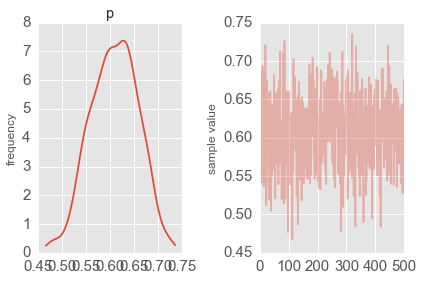

In [6]:
fit.plot('p');
plt.tight_layout()

### Estimating mean and standard deviation of normal distribution

$$
X \sim \mathcal{N}(\mu, \sigma^2)
$$

In [7]:
norm_code = """
data {
    int<lower=0> n; 
    real y[n]; 
}
transformed data {}
parameters {
    real<lower=0, upper=100> mu;
    real<lower=0, upper=10> sigma;
}
transformed parameters {}
model {
    y ~ normal(mu, sigma);
}
generated quantities {}
"""

norm_dat = {
             'n': 100,
             'y': np.random.normal(10, 2, 100),
            }

fit = pystan.stan(model_code=norm_code, data=norm_dat, iter=1000, chains=1)

In [8]:
fit

Inference for Stan model: anon_model_3318343d5265d1b4ebc1e443f0228954.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     10.07    0.02   0.22   9.64   9.91  10.07  10.22  10.48    133    1.0
sigma   2.02    0.01   0.15   1.76   1.93   2.01   2.12   2.33    127   1.02
lp__  -117.3     0.1   1.02 -119.9 -117.7 -117.0 -116.5 -116.2    103    1.0

Samples were drawn using NUTS(diag_e) at Tue Mar  1 07:31:19 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [9]:
trace = fit.extract()

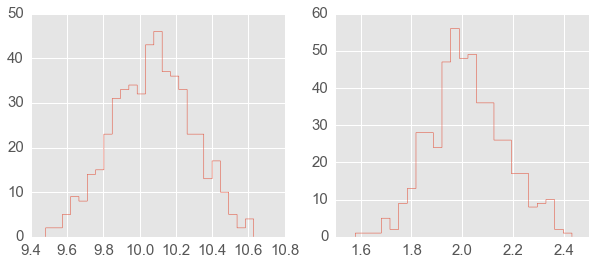

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); 
plt.hist(trace['mu'][:], 25, histtype='step');
plt.subplot(1,2,2); 
plt.hist(trace['sigma'][:], 25, histtype='step');

#### Optimization (finding MAP)

In [11]:
sm = pystan.StanModel(model_code=norm_code)
op = sm.optimizing(data=norm_dat)
op

OrderedDict([('mu', array(10.070206723560238)),
             ('sigma', array(1.9913542540072449))])

#### Reusing fitted objects

In [12]:
new_dat = {
             'n': 100,
             'y': np.random.normal(10, 2, 100),
            }

In [13]:
fit2 = pystan.stan(fit=fit, data=new_dat, chains=1)

In [14]:
fit2

Inference for Stan model: anon_model_3318343d5265d1b4ebc1e443f0228954.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      9.89    0.01    0.2   9.51   9.76   9.89  10.02  10.29    276    1.0
sigma    2.0  9.3e-3   0.14   1.75   1.89   1.99   2.08    2.3    226    1.0
lp__  -115.4    0.08   0.96 -118.2 -115.7 -115.1 -114.7 -114.5    151   1.01

Samples were drawn using NUTS(diag_e) at Tue Mar  1 07:32:02 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

#### Saving compiled models

We can also compile Stan models and save them to file, so as to reload them for later use without needing to recompile.

In [17]:
def save(obj, filename):
    """Save compiled models for reuse."""
    import pickle
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
    """Reload compiled models for reuse."""
    import pickle
    return pickle.load(open(filename, 'rb'))

In [18]:
model = pystan.StanModel(model_code=norm_code)
save(model, 'norm_model.pic')

In [19]:
new_model = load('norm_model.pic')
fit4 = new_model.sampling(new_dat, chains=1)
fit4

Inference for Stan model: anon_model_3318343d5265d1b4ebc1e443f0228954.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       9.9    0.01    0.2   9.52   9.77    9.9  10.05  10.27    258    1.0
sigma   1.99  9.7e-3   0.15   1.73   1.89   1.98   2.08   2.32    252    1.0
lp__  -115.5    0.08   1.08 -118.5 -116.0 -115.2 -114.8 -114.5    167    1.0

Samples were drawn using NUTS(diag_e) at Tue Mar  1 07:48:40 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

### Estimating parameters of a linear regression model

We will show how to estimate regression parameters using a simple linear model

$$
y \sim ax + b
$$

We can restate the linear model $$y = ax + b + \epsilon$$ as sampling from a probability distribution

$$
y \sim \mathcal{N}(ax + b, \sigma^2)
$$

We will assume the following priors

$$
a \sim \mathcal{N}(0, 100) \\
b \sim \mathcal{N}(0, 100) \\
\sigma \sim \mathcal{U}(0, 20)
$$

In [20]:
lin_reg_code = """
data {
    int<lower=0> n; 
    real x[n];
    real y[n]; 
}
transformed data {}
parameters {
    real a;
    real b;
    real sigma;
}
transformed parameters {
    real mu[n];
    for (i in 1:n) {
        mu[i] <- a*x[i] + b;
        }
}
model {
    sigma ~ uniform(0, 20);
    y ~ normal(mu, sigma);
}
generated quantities {}
"""

n = 11
_a = 6
_b = 2
x = np.linspace(0, 1, n)
y = _a*x + _b + np.random.randn(n)

lin_reg_dat = {
             'n': n,
             'x': x,
             'y': y
            }

fit = pystan.stan(model_code=lin_reg_code, data=lin_reg_dat, iter=1000, chains=1)

In [21]:
fit

Inference for Stan model: anon_model_4bdbb0aeaf5fafee91f7aa8b257093f2.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a        7.26     0.1   0.89   5.62   6.73   7.27   7.78   9.04     82   1.03
b        1.52    0.06   0.54   0.44    1.2   1.56   1.85   2.51     92   1.03
sigma    0.88    0.03   0.28   0.54    0.7   0.82   0.99   1.58     71   1.01
mu[0]    1.52    0.06   0.54   0.44    1.2   1.56   1.85   2.51     92   1.03
mu[1]    2.25    0.05   0.46   1.27   1.97   2.29   2.53   3.13     95   1.02
mu[2]    2.97    0.04   0.39   2.13   2.74   3.01    3.2   3.71    100   1.02
mu[3]     3.7    0.03   0.33   2.97   3.51   3.72   3.89   4.36    110   1.02
mu[4]    4.42    0.03   0.29   3.82   4.26   4.44    4.6   4.99    125   1.01
mu[5]    5.15    0.02   0.27   4.63   4.99   5.16   5.32   5.68    145    1.0
mu[6]    5.88    0.02   0.28    5.

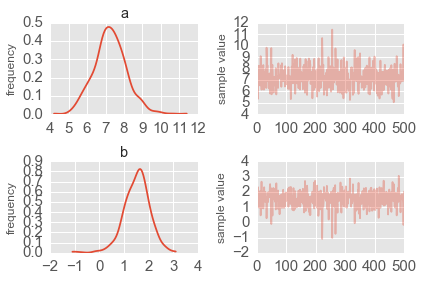

In [22]:
fit.plot(['a', 'b']);
plt.tight_layout()

### Simple Logistic model

We have observations of height and weight and want to use a logistic model to guess the sex.

In [23]:
# observed data
df = pd.read_csv('HtWt.csv')
df.head()

,male,height,weight
0,0,63.2,168.7
1,0,68.7,169.8
2,0,64.8,176.6
3,0,67.9,246.8
4,1,68.9,151.6


In [24]:
log_reg_code = """
data {
    int<lower=0> n; 
    int male[n];
    real weight[n];
    real height[n];
}
transformed data {}
parameters {
    real a;
    real b;
    real c;
}
transformed parameters {}
model {
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    c ~ normal(0, 10);
    for(i in 1:n) {
        male[i] ~ bernoulli(inv_logit(a*weight[i] + b*height[i] + c));
  }
}
generated quantities {}
"""

log_reg_dat = {
             'n': len(df),
             'male': df.male,
             'height': df.height,
             'weight': df.weight
            }

fit = pystan.stan(model_code=log_reg_code, data=log_reg_dat, iter=2000, chains=1)

In [25]:
fit

Inference for Stan model: anon_model_bbf283522d1e199c049bb423b4a6e0da.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      0.25    0.11   0.19-4.4e-4   0.02   0.38    0.4   0.41      3   2.28
b     -0.61    0.28   0.48  -1.05  -1.01  -0.94  -0.01   0.03      3   2.34
c     -0.31    0.64   1.11   -2.3  -1.63   0.49    0.5    0.5      3   1.78
lp__ -191.2   66.47 115.13 -305.7 -289.3 -265.0 -47.06  -45.1      3   2.47

Samples were drawn using NUTS(diag_e) at Tue Mar  1 08:01:40 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

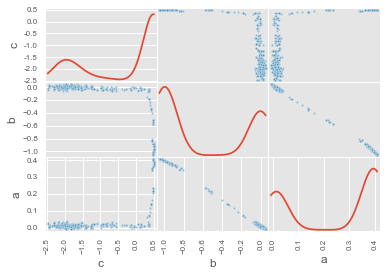

In [26]:
df_trace = pd.DataFrame(fit.extract(['c', 'b', 'a']))
pd.scatter_matrix(df_trace[:], diagonal='kde');

### Estimating parameters of a logistic model

Gelman's book has an example where the dose of a drug may be affected to the number of rat deaths in an experiment.

| Dose (log g/ml) | # Rats | # Deaths |
|-----------------|--------|----------|
| -0.896          | 5      | 0        |
| -0.296          | 5      | 1        |
| -0.053          | 5      | 3        |
| 0.727           | 5      | 5        |

We will model the number of deaths as a random sample from a binomial distribution, where $n$ is the number of rats and $p$ the probability of a rat dying. We are given $n = 5$, but we believe that $p$ may be related to the drug dose $x$. As $x$ increases the number of rats dying seems to increase, and since $p$ is a probability, we use the following model:

$$
y \sim \text{Bin}(n, p) \\
\text{logit}(p) = \alpha + \beta x \\
\alpha \sim \mathcal{N}(0, 5) \\
\beta \sim \mathcal{N}(0, 10)
$$

where we set vague priors for $\alpha$ and $\beta$, the parameters for the logistic model.

#### Original PyMC3 code

```python
n = 5 * np.ones(4)
x = np.array([-0.896, -0.296, -0.053, 0.727])
y = np.array([0, 1, 3, 5])

def invlogit(x):
    return pm.exp(x) / (1 + pm.exp(x))

with pm.Model() as model:
    # define priors
    alpha = pm.Normal('alpha', mu=0, sd=5)
    beta = pm.Flat('beta')
    
    # define likelihood
    p = invlogit(alpha + beta*x)
    y_obs = pm.Binomial('y_obs', n=n, p=p, observed=y)
    
    # inference
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(niter, step, start, random_seed=123, progressbar=True)
```

**Exercise** - convert to PyStan version

### Using a hierarchical model

This uses the Gelman radon data set and is based off this [IPython notebook](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/). Radon levels were measured in houses from all counties in several states. Here we want to know if the preence of a basement affects the level of radon, and if this is affected by which county the house is located in. 

The data set provided is just for the state of Minnesota, which has 85 counties with 2 to 116 measurements per county. We only need 3 columns for this example `county`, `log_radon`, `floor`, where `floor=0` indicates that there is a basement.

We will perform simple linear regression on log_radon as a function of county and floor.

In [ ]:
radon = pd.read_csv('radon.csv')[['county', 'floor', 'log_radon']]
radon.head()

#### Hiearchical model

With a hierarchical model, there is an $a_c$ and a $b_c$ for each county $c$ just as in the individual county model, but they are no longer independent but assumed to come from a common group distribution

$$
a_c \sim \mathcal{N}(\mu_a, \sigma_a^2) \\
b_c \sim \mathcal{N}(\mu_b, \sigma_b^2)
$$

we further assume that the hyperparameters come from the following distributions

$$
\mu_a \sim \mathcal{N}(0, 100^2) \\
\sigma_a \sim \mathcal{U}(0, 100) \\ 
\mu_b \sim \mathcal{N}(0, 100^2) \\
\sigma_b \sim \mathcal{U}(0, 100)
$$

#### Original PyMC3 code

```python
county = pd.Categorical(radon['county']).codes

with pm.Model() as hm:
    # County hyperpriors
    mu_a = pm.Normal('mu_a', mu=0, tau=1.0/100**2)
    sigma_a = pm.Uniform('sigma_a', lower=0, upper=100)
    mu_b = pm.Normal('mu_b', mu=0, tau=1.0/100**2)
    sigma_b = pm.Uniform('sigma_b', lower=0, upper=100)
    
    # County slopes and intercepts
    a = pm.Normal('slope', mu=mu_a, sd=sigma_a, shape=len(set(county)))
    b = pm.Normal('intercept', mu=mu_b, tau=1.0/sigma_b**2, shape=len(set(county)))
    
    # Houseehold errors
    sigma = pm.Gamma("sigma", alpha=10, beta=1)
    
    # Model prediction of radon level
    mu = a[county] + b[county] * radon.floor.values
    
    # Data likelihood
    y = pm.Normal('y', mu=mu, sd=sigma, observed=radon.log_radon)
```

**Exercise** - convert to PyStan version